In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
shap.initjs()
import seaborn as sns
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE
import joblib
import warnings
import gc

gc.collect()

warnings.filterwarnings("ignore")

df = pd.read_csv("FraudAnalysis_24June.csv")

c:\Users\ehab.zaidi\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def RepeatedLoss(count_repeated_losses, profit, symbol, login):
    if profit<0:
        count_repeated_losses.loc[symbol, login] +=1
    else:
        count_repeated_losses.loc[symbol, login]= 0
    return count_repeated_losses.loc[symbol, login]

In [3]:
def HighFrequency(count_high_frequency, login, seconds):
    if (seconds/(60.0*60.0))>24:
        count_high_frequency.loc[login, 0] = 0
    count_high_frequency.loc[login, 0]+=1
    return count_high_frequency.loc[login,0]

In [4]:
def is_Fraud(row, count_repeated_losses, count_high_frequency):
    if row[" Volume"] != 0:
        if row[" Profit"]/row[" Volume"]>=200:
            return True
    elif row[" Profit"]>=500 and row[" Seconds"]<=3:
        return True
    elif row[" Volume"]>=5 and row[" Profit"]>=1000 and (row[" Seconds"]/60.0)<2:
        return True
    elif row[" Profit"]>=2000 and (row[" Seconds"]/60.0)<=10:
        return True
    elif (row[" Seconds"])<=10:
        return True
    elif row[" ServerCode"] == "mt5-live-011" and row[" Profit"]>500 and (row[" Seconds"]/(60.0*60.0))>=36:
        return True
    elif RepeatedLoss(count_repeated_losses, row[" Profit"], row[" Symbol"], row["AccountNumber"])>10:
        return True
    elif HighFrequency(count_high_frequency, row["AccountNumber"], row[" Seconds"])>100:
        return True
    
    return False

In [5]:
def Run_Model(df):
    scaler = StandardScaler()

    

    X = df[["TradesLastMin", "TimeSinceLastTrade", "AvgProfit", " VolumeClosed"]]
    y = df["Fraud"]
    weights = df["Fraud"].apply(lambda x: 3 if x ==1 else 1)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    model = LGBMClassifier(
        objective= 'binary',
        scale_pos_weight = 1754,
        learning_rate= 0.2,
        n_estimators=300,
        num_leaves=31,
        verbosity = -1,

    )
    model.fit(X_resampled, y_resampled)
    return model


In [6]:
def generate_features_data(df):
    parsed_times = df[" ParsedTime"].values
    profits = df[" Profit"].values

    num_trades_last_min = []
    avg_profits_last_min = []
    loss_counts = []

    for i in range(len(df)):
        curr_time = parsed_times[i]

        mask = parsed_times[:i]>= (curr_time - np.timedelta64(5, 's'))
        recent_trades = profits [:i][mask]

        num_trades_last_min.append(len(recent_trades))
        avg_profits_last_min.append(profits[:i].mean() if i >0 else 0.0)
        loss_counts.append((profits[:i]<0).sum())
    
    df = df.sort_values(by=[" ParsedTime"])
    df["TimeSinceLastTrade"] = df[" ParsedTime"].diff().dt.total_seconds()
    df["TimeSinceLastTrade"]= df["TimeSinceLastTrade"].fillna(-1)
    df["TradesLastMin"] = num_trades_last_min
    df["AvgProfit"] = avg_profits_last_min
    df["LossCount"] = loss_counts

    return df

In [7]:
def generate_features_new_trade(incoming_trade, df):
    account_number = incoming_trade["AccountNumber"][0]
    account_history = df[df["AccountNumber"] == account_number]
    if len(account_history) == 0:
        account_history = pd.concat([account_history, incoming_trade[account_history.columns]])
        account_history["TradesLastMin"] = 0
        account_history["AvgProfit"] = incoming_trade[" Profit"]
        account_history["TimeSinceLastTrade"] = 0
        account_history["LossCount"] = 1 if incoming_trade[" Profit"]<0 else 0
        return account_history.loc[0]
    account_history = pd.concat([account_history, incoming_trade[account_history.columns]])
    account_history.sort_values(by = " TimeCreateUtc").reset_index(drop=True)
    account_history = generate_features_data(account_history)
    return account_history.loc[0]

In [8]:
logins = df["AccountNumber"].unique().tolist()
symbols = df[" Symbol"].unique().tolist()

zero_matrix = np.zeros((len(symbols), len(logins)))

count_repeated_losses = pd.DataFrame(zero_matrix, index=symbols, columns=logins)

zero_row = [0 for i in range(len(logins))]
count_high_frequency = pd.DataFrame(zero_row, index=logins)


df[" ParsedTime"] = pd.to_datetime(df[" TimeCreateUtc"], format ="%Y-%m-%d %H:%M:%S.%f0", utc=True )
df = df.sort_values(by = [" PositionId", " OrderId"])
df[" Seconds"] = df.groupby(" PositionId")[" ParsedTime"].diff().dt.total_seconds()
df["Fraud"] = df.apply(is_Fraud, axis=1, args = (count_repeated_losses, count_high_frequency))
df["Fraud"] = df["Fraud"].map({True: 1, False: 0}).astype(int)
print(df.dtypes)


AccountNumber                   int64
 ServerCode                    object
 OrderId                        int64
 PositionId                     int64
 Action                         int64
 Symbol                        object
 DealDate                      object
 Price                        float64
 Volume                         int64
 Profit                       float64
 VolumeClosed                   int64
 PriceSl                      float64
 PriceTp                      float64
 PricePosition                float64
 ProfitRaw                    float64
 TimeMsc                        int64
 TimeCreateUtc                 object
 ParsedTime       datetime64[ns, UTC]
 Seconds                      float64
Fraud                           int64
dtype: object


In [9]:
le = LabelEncoder()
df = df.sort_values(by=" ParsedTime")
df = df.groupby("AccountNumber", group_keys=False).apply(generate_features_data)

In [10]:
data = pd.read_csv("FraudAnalysis_24June.csv")

model = Run_Model(df)
data[" ParsedTime"] = pd.to_datetime(data[" TimeCreateUtc"], format ="%Y-%m-%d %H:%M:%S.%f0", utc=True )
data[" Seconds"] = 0.0

data = data.groupby("AccountNumber", group_keys=False).apply(generate_features_data) 
X_input = data[["TradesLastMin","TimeSinceLastTrade", "AvgProfit", " VolumeClosed"]]
y = df["Fraud"]


Accuracy for LightGBM:  88.49334825462749


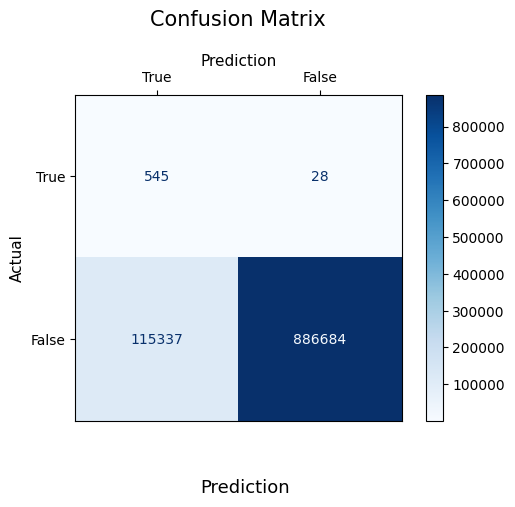

In [11]:
prediction = model.predict_proba(X_input)[:, 1]
preds = (prediction > 0.9).astype(int)

preds = np.round(preds)
accuracy = accuracy_score(y, preds)
print("Accuracy for LightGBM: ", accuracy*100)

Fraud = [True, False]
cm = confusion_matrix(y, preds, labels= Fraud )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Fraud)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

In [ ]:
incoming_trade = pd.read_csv("Smaller.csv") #Incoming trade from a client
model = Run_Model(df)

incoming_trade[" ParsedTime"] = pd.to_datetime(incoming_trade[" TimeCreateUtc"], format ="%Y-%m-%d %H:%M:%S.%f0", utc=True )
incoming_trade[" Seconds"] = 0.0
incoming_trade["Fraud"] = 0
incoming_trade["TimeSinceLastTrade"] = -1
incoming_trade["TradesLastMin"] = 0
incoming_trade["AvgProfit"] = 0.0
incoming_trade["LossCount"] = 0

incoming_trade = generate_features_new_trade(incoming_trade, df)
print(df.shape)

X_input = incoming_trade[["TradesLastMin", "TimeSinceLastTrade","AvgProfit", " VolumeClosed"]].to_frame().T
X_input = X_input.astype({
    "TradesLastMin": float,
    "TimeSinceLastTrade": float,
    "AvgProfit": float, 
    " VolumeClosed": int
})

fraud = model.predict_proba(X_input)[0][1]
print(fraud)
if (fraud > 0.5):
    incoming_trade["Fraud"] = 1
else:
    incoming_trade["Fraud"] = 0

df.loc[len(df)] = incoming_trade
df.sort_values(by = " TimeCreateUtc", ascending=True).reset_index(drop=True, inplace=True)
df.drop(index = 0, inplace=True)


print(df.shape)

(1002594, 24)
1.0
(1002594, 24)


In [13]:
df.tail()

,AccountNumber,ServerCode,OrderId,PositionId,Action,Symbol,DealDate,Price,Volume,Profit,...,ProfitRaw,TimeMsc,TimeCreateUtc,ParsedTime,Seconds,Fraud,TimeSinceLastTrade,TradesLastMin,AvgProfit,LossCount
1002399,1017068494,mt5-live-02,2000363369,2000363369,1,XAUUSD.p,2025-06-24 15:41:43.0000000,3306.03,100,0.00,...,0.00,1750779703669,2025-06-24 12:41:43.0000000,2025-06-24 12:41:43+00:00,NaN,0,32.0,0,-0.145846,38
1002401,1017068494,mt5-live-02,2000363370,2000363370,0,XAUUSD.p,2025-06-24 15:42:47.0000000,3307.03,100,0.00,...,0.00,1750779767949,2025-06-24 12:42:47.0000000,2025-06-24 12:42:47+00:00,NaN,0,64.0,0,-0.144733,38
1002402,1017068494,mt5-live-02,2000363371,2000363370,1,XAUUSD.p,2025-06-24 15:47:13.0000000,3309.99,100,2.96,...,2.96,1750780033932,2025-06-24 12:47:13.0000000,2025-06-24 12:47:13+00:00,266.0,0,266.0,0,-0.143636,38
1002400,1017068494,mt5-live-02,2000363372,2000363369,0,XAUUSD.p,2025-06-24 15:47:14.0000000,3310.43,100,-4.40,...,-4.40,1750780034092,2025-06-24 12:47:14.0000000,2025-06-24 12:47:14+00:00,331.0,0,1.0,1,-0.120301,38
1002594,3102116,live-equiti-com-3,11167060,11167060,2,NaN,2025-06-24 16:03:10.0000000,0.00,1,10000.00,...,0.00,301024,2025-06-24 16:03:10.0000000,2025-06-24 16:03:10+00:00,0.0,1,9950.0,0,448.050526,11


In [14]:
explainer = shap.TreeExplainer(model)

shap_values1 = explainer.shap_values(X_input)
shap.plots.force(explainer.expected_value, shap_values1, feature_names= ["TradesLastMin", "TimeSinceLastTrade","AvgProfit", " VolumeClosed"]
)

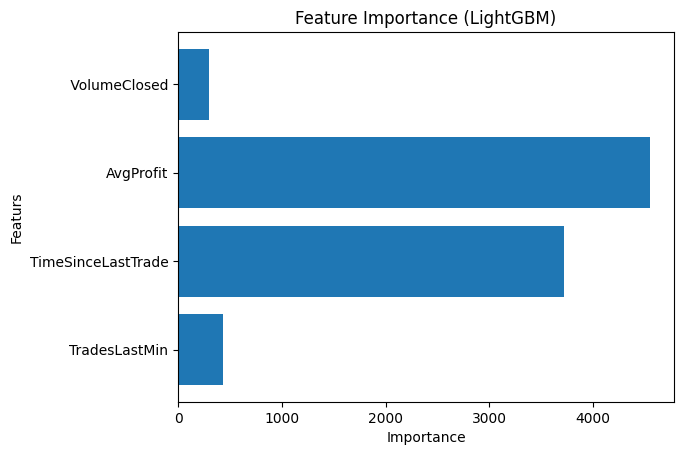

In [15]:
importances = model.feature_importances_
features = ["TradesLastMin", "TimeSinceLastTrade","AvgProfit", " VolumeClosed"]

plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Featurs")
plt.title("Feature Importance (LightGBM)")
plt.show()

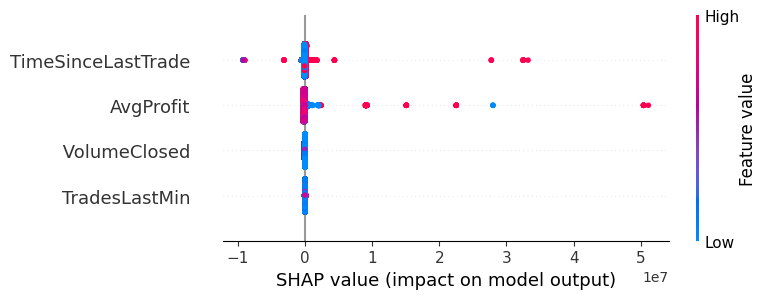

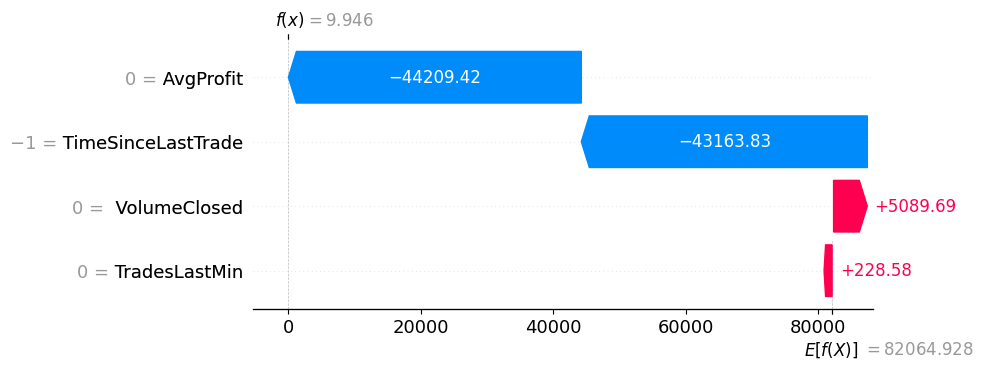

In [16]:
shap_values2 = explainer(df[["TradesLastMin", "TimeSinceLastTrade","AvgProfit", " VolumeClosed"]])

shap.summary_plot(shap_values2, df[["TradesLastMin","TimeSinceLastTrade", "AvgProfit", " VolumeClosed"]])

shap.plots.waterfall(shap_values2[0])


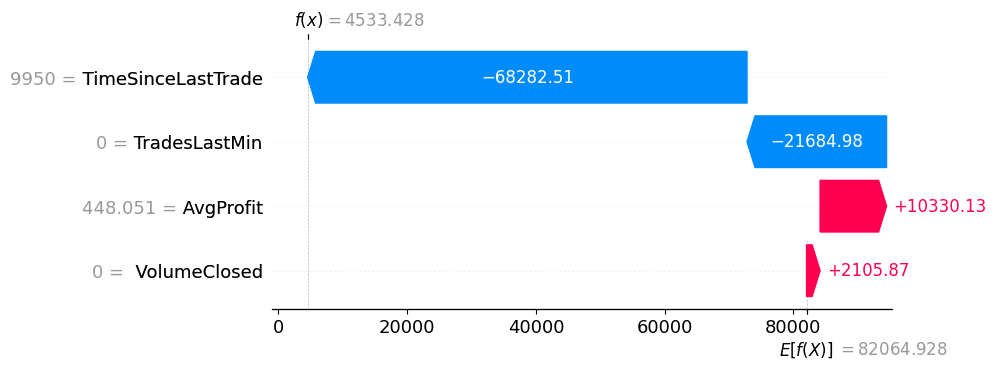

In [17]:
shap.plots.waterfall(shap_values2[1002593])